In [1]:
from os.path import expanduser
from urllib import request, parse, error
import json
import numpy as np
import os
import shutil
import spacy
import sqlite3

In [2]:
CHROME_HISTORY_FILE = expanduser('~/Library/Application Support/Google/Chrome/Default/History')
WORK_DIR = expanduser('~/Data/')
CACHE_DIR = os.path.join(WORK_DIR, "Cache")
HISTORY = os.path.join(WORK_DIR, 'history.sqlite')

def init():
    if not os.path.exists(CACHE_DIR):
        os.makedirs(CACHE_DIR)
    shutil.copyfile(CHROME_HISTORY_FILE, HISTORY)
    
init()

In [3]:
def visited_wiki_pages():
    conn = sqlite3.connect(HISTORY)
    cur = conn.cursor()
    cur.execute("select url from urls")
    urls = cur.fetchall()

    def is_wiki_page(url):
        u = parse.urlsplit(url)
        return "en.wikipedia.org" in u.netloc and "/wiki/" in u.path and not ":" in parse.unquote(u.path)

    def page_name(str):
        path = parse.urlparse(str).path
        return parse.unquote(path).replace("/wiki/", "").replace("_", " ")

    pages = set(page_name(u[0]) for u in urls if is_wiki_page(u[0]))
    return pages

pages = visited_wiki_pages()
pages


{'2016–17 Northern Rakhine State clashes',
 '2017 WTA Finals – Singles',
 'A Visit From the Goon Squad',
 'A Visit from the Goon Squad',
 'ATP Rankings',
 'Agadez',
 'Agatha Christie',
 "All the King's Men",
 'Ambrosian chant',
 'Anacrusis',
 'Ann Miller',
 'Archibald Selwyn',
 'Association rule learning',
 'Atlantic Canada',
 'Authorship of the Bible',
 'Bar (music)',
 'Basis (linear algebra)',
 'Bassoon',
 'Berkovich space',
 'Bible',
 'Big Shot (ride)',
 'Bivouac shelter',
 'Bix Beiderbecke',
 'Bloomberg Terminal',
 'Blurb',
 'Bramble',
 'Brandenburg Concertos',
 'Brass instrument',
 'Bra–ket notation',
 'Brogue shoe',
 'Cantonese',
 'Cantonese Yale',
 'Cantonese phonology',
 'Cecil Roth',
 'Chromatic scale',
 'Chukchi language',
 'Chum (tent)',
 'Circle of fifths',
 'Collatz conjecture',
 'Concerto for Orchestra (Bartók)',
 'Congress of Aboriginal Peoples',
 'Cornet',
 'Crataegus',
 'Cross product',
 'Cutting contest',
 'Degenerate music',
 'Delray Beach International Tennis Champi

In [4]:
# nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_vectors_web_lg')

In [5]:
def prepare_wiki_url(title, sentences):
    """ Builds query url for wikipedia extracts. For API details please see:
    https://en.wikipedia.org/w/api.php?action=help&modules=query%2Bextracts
    """
    
    WIKI_API = 'https://en.wikipedia.org/w/api.php'

    data = {}
    data['action'] = 'query'
    data['prop'] = 'extracts|categories'
    data['titles'] = title
    data['exsentences'] = sentences
    data['explaintext'] = True
    data['exintro'] = True
    data['redirects'] = True
    data['format'] = 'json'  
    data['exlimit'] = 20
    data['clcategories'] = 'Category:Disambiguation pages'
    
    url_values = parse.urlencode(data)
    full_url = WIKI_API + '?' + url_values
    return full_url

In [6]:
url = prepare_wiki_url('Kurt Cobain', 5)
url

'https://en.wikipedia.org/w/api.php?action=query&prop=extracts%7Ccategories&titles=Kurt+Cobain&exsentences=5&explaintext=True&exintro=True&redirects=True&format=json&exlimit=20&clcategories=Category%3ADisambiguation+pages'

In [7]:
def request_wiki_info(url):
    """Downloads an extract in JSON format from a wikipedia page with given title.
    We can control number of sentences returned (up to 10).
    Returns string.
    """
    req = request.Request(url)
 
    try:
        response = request.urlopen(req)
    except error.URLError as e:
        if hasattr(e, 'reason'):
            print('We failed to reach a server.')
            print('Reason: ', e.reason)
        elif hasattr(e, 'code'):
            print("The server couldn't fulfill the request.")
            print('Error code: ', e.code)
    else:
        data = response.read()
        return data

In [8]:
resp = request_wiki_info(url)
resp

b'{"batchcomplete":"","query":{"pages":{"16707":{"pageid":16707,"ns":0,"title":"Kurt Cobain","extract":"Kurt Donald Cobain (February 20, 1967 \\u2013 April 5, 1994) was an American singer, musician, and songwriter. Born in Aberdeen, Washington, Cobain formed the band Nirvana with Krist Novoselic and Aaron Burckhard in 1987 and established it as part of the Seattle music scene which later became known as grunge. Nirvana\'s debut album Bleach was released on the independent record label Sub Pop in 1989.\\nAfter signing with major label DGC Records, Nirvana found breakthrough success with \\"Smells Like Teen Spirit\\" from their second album Nevermind (1991). Following the success of Nevermind, Nirvana was labeled \\"the flagship band\\" of Generation X, and Cobain hailed as \\"the spokesman of a generation\\"."}}}}'

In [9]:
def parse_wiki_info(resp):    
    js = json.loads(resp)
    for v in js['query']['pages'].values():
        if 'missing' in v or not 'extract' in v:
            print('Extract', title, 'is missing')
            return None
        else:
            extract = v['extract']
            is_disambiguation = 'categories' in v
            break
    return {'extract': extract, 'is_disambiguation': is_disambiguation}

In [10]:
info = parse_wiki_info(resp)
info

{'extract': 'Kurt Donald Cobain (February 20, 1967 – April 5, 1994) was an American singer, musician, and songwriter. Born in Aberdeen, Washington, Cobain formed the band Nirvana with Krist Novoselic and Aaron Burckhard in 1987 and established it as part of the Seattle music scene which later became known as grunge. Nirvana\'s debut album Bleach was released on the independent record label Sub Pop in 1989.\nAfter signing with major label DGC Records, Nirvana found breakthrough success with "Smells Like Teen Spirit" from their second album Nevermind (1991). Following the success of Nevermind, Nirvana was labeled "the flagship band" of Generation X, and Cobain hailed as "the spokesman of a generation".',
 'is_disambiguation': False}

In [11]:
kurt_cobain = nlp(info['extract'])
kurt_cobain

Kurt Donald Cobain (February 20, 1967 – April 5, 1994) was an American singer, musician, and songwriter. Born in Aberdeen, Washington, Cobain formed the band Nirvana with Krist Novoselic and Aaron Burckhard in 1987 and established it as part of the Seattle music scene which later became known as grunge. Nirvana's debut album Bleach was released on the independent record label Sub Pop in 1989.
After signing with major label DGC Records, Nirvana found breakthrough success with "Smells Like Teen Spirit" from their second album Nevermind (1991). Following the success of Nevermind, Nirvana was labeled "the flagship band" of Generation X, and Cobain hailed as "the spokesman of a generation".

In [12]:
def from_cache(title):
    wiki_path = to_file_name(title, 'wiki')
    if os.path.exists(wiki_path):
        with open(wiki_path, 'r') as f:
            dump = json.loads(f.read())
            return dump

def save_to_cache(title, wiki_info):
    wiki_path = to_file_name(title, 'wiki')
    with open(wiki_path, 'w') as f:
        dump = json.dumps(wiki_info)
        f.write(dump)

def to_file_name(title, ext):
    base = "".join(c.replace(" ", "_") 
                   for c in title 
                   if c.isalnum() or c in {"_", "-", " ", "(", ")"})
    return os.path.join(CACHE_DIR, base + "." + ext)

In [24]:
def analyze(title, sentences=5):
    dump = from_cache(title)
    if dump is None:
        url = prepare_wiki_url(title, sentences)
        resp = request_wiki_info(url)
        info = parse_wiki_info(resp)
        save_to_cache(title, info)
        if info['is_disambiguation']:
            return None
        else:
            doc = nlp(info['extract'])
            return title, doc
    elif dump['is_disambiguation']:
        return None
    else:
        return title, nlp(dump['extract'])

In [25]:
krist_novoselic = analyze('Krist Novoselic')[1]
lady_gaga = analyze('Lady Gaga')[1]

print(kurt_cobain.similarity(krist_novoselic))
print(kurt_cobain.similarity(lady_gaga))

0.966928213746
0.930585500224


In [26]:
def similarity_matrix(pages):
    infos  = [i for i in map(analyze, pages) if i is not None]
    docs   = [i[1] for i in infos]
    titles = [i[0] for i in infos]
    
    def sim_f(i, j):
        return docs[i].similarity(docs[j])
    
    n = len(infos)
    return titles, np.fromfunction(np.vectorize(sim_f), (n, n), dtype=int)

In [27]:
good_titles, matrix = similarity_matrix(list(pages))
matrix

array([[ 0.99999995,  0.85268153,  0.87218339, ...,  0.93247133,
         0.77692595,  0.9003382 ],
       [ 0.85268153,  0.99999993,  0.8297727 , ...,  0.90466518,
         0.88846709,  0.87936612],
       [ 0.87218339,  0.8297727 ,  0.99999986, ...,  0.84394398,
         0.82081569,  0.87891169],
       ..., 
       [ 0.93247133,  0.90466518,  0.84394398, ...,  1.00000011,
         0.82817086,  0.90408085],
       [ 0.77692595,  0.88846709,  0.82081569, ...,  0.82817086,
         0.99999993,  0.82093003],
       [ 0.9003382 ,  0.87936612,  0.87891169, ...,  0.90408085,
         0.82093003,  0.99999999]])

In [28]:
matrix.shape

(220, 220)

In [29]:
import sklearn.cluster

affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.8)
affprop.fit(matrix)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.8, max_iter=200, preference=None, verbose=False)

In [30]:
affprop.cluster_centers_indices_

array([  8,   9,  10,  16,  20,  21,  28,  45,  48,  53,  60,  64,  66,
        78,  97,  98, 104, 111, 115, 125, 141, 187, 207])

In [31]:
len(affprop.cluster_centers_indices_)

23

In [36]:
ts = np.asarray(good_titles)

for cluster_id in np.unique(affprop.labels_):
    exemplar = ts[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(ts[np.nonzero(affprop.labels_ == cluster_id)])
    cluster_str = ", ".join(cluster)
    print(f' - [{exemplar}]: {cluster_str}')

 - [Kingdom of the Isles]: Fieldway (ward), Gallery of country coats of arms, Isle of Man, Isle of Man passport, Kingdom of the Isles, Norn language, Orkneyinga Saga, Orkneyinga saga, Prehistoric Shetland, Scots language, Shetland
 - [Viktor Ullmann]: Viktor Ullmann
 - [List of Stradivarius instruments]: List of Stradivarius instruments
 - [Cantonese Yale]: Cantonese Yale, Cantonese phonology, Ejective consonant, S. L. Wong (phonetic symbols), S. L. Wong (romanisation), Uvular consonant, Yale romanization of Cantonese
 - [Norm (mathematics)]: Basis (linear algebra), Berkovich space, Bra–ket notation, Cross product, Distribution (mathematics), Divisor function, Dot product, Ellipse, Ellipsoid, G-force, Gram–Schmidt process, Inner product space, Linear independence, Linearly independent, Magnitude (vector), Norm (mathematics), Orthogonal basis, Orthonormal basis, Rational number, Reciprocal distribution, Sign sequence, Vector space
 - [Lucas Geniušas]: Archibald Selwyn, Cecil Roth, Hans 

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(metric="precomputed", method="exact",random_state=42)
tsne.fit(abs(1 - matrix))

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='exact', metric='precomputed', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=42, verbose=0)

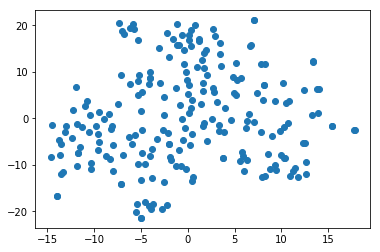

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, axes = plt.subplots()
data = tsne.embedding_
axes.scatter(data[:,0], data[:,1])